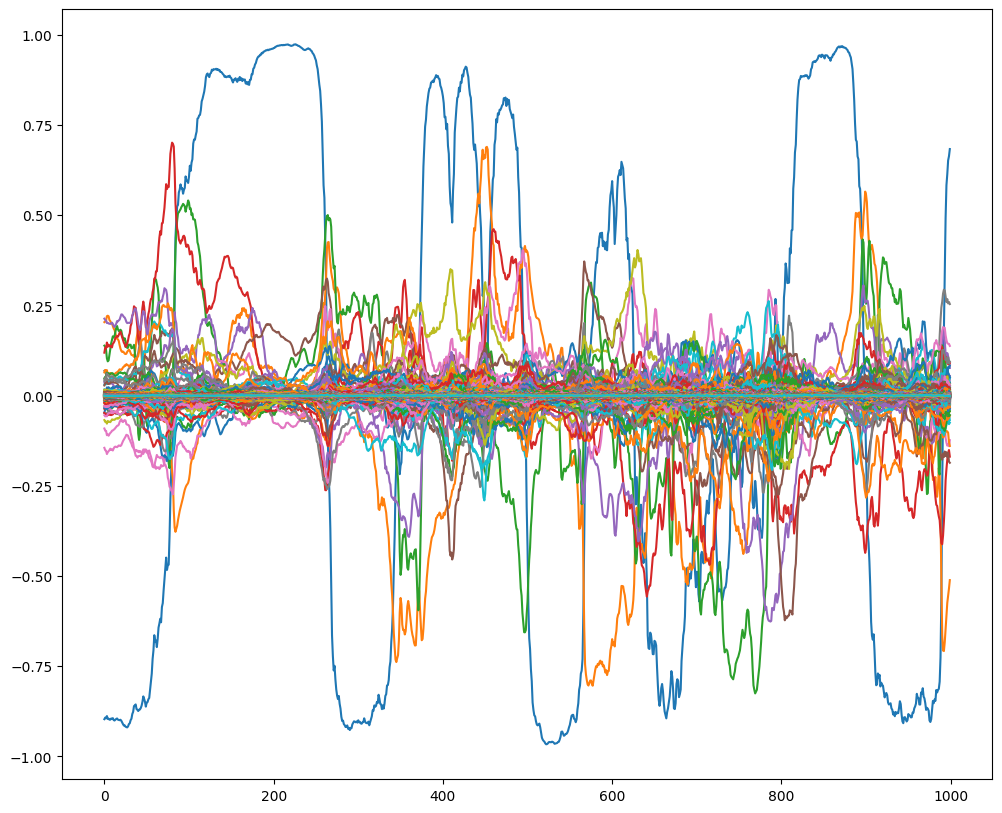

(10, 5000)
(10, 5000)
(10, 2000)
(10, 2000)
(500, 10000)


In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from numba import jit, prange

import reservoirpy as rpy
from sklearn.preprocessing import normalize
rpy.set_seed(42)

from reservoirpy.observables import nrmse, rsquare

############
@jit(target_backend='cuda')
def scaling_numba1(a):
    mean = np.zeros((1, a.shape[1]))
    for j in prange(a.shape[1]):
        for i in prange(a.shape[0]):
            mean[0, j] = mean[0, j] + a[i, j]

        mean[0, j] = mean[0, j] / a.shape[0]

    std = np.zeros((1, a.shape[1]))
    for j in prange(a.shape[1]):
        ss = float(0)
        for i in prange(a.shape[0]):
            ss = ss + (a[i, j] - mean[0, j]) ** 2
        std[0, j] = np.sqrt(ss / a.shape[0])

    for j in prange(a.shape[1]):
        for i in prange(a.shape[0]):
            a[i, j] = (a[i, j] - mean[0, j]) / std[0, j]

    return a, mean, std


WF_data = np.load('../data/data_WF_PCA_projections_small.npy')

# print(WF_data.shape)

# print(WF_data[:,0])

# WF_scaled,_,_ = scaling_numba1(WF_data)
#
# print(WF_scaled[:,0])
#
# np.linalg.norm(WF_scaled[:,0])

WF_data_scaled = WF_data / np.linalg.norm(WF_data,2,0)


fig = plt.figure(figsize=(12,10))
plt.plot(np.arange(0, 1000), WF_data_scaled[:, :1000].T, label="Training data")
plt.show()


WF_trainX = WF_data_scaled[:10,:5000]
WF_trainY = WF_data_scaled[:10,1:5001]
print(WF_trainX.shape)
print(WF_trainY.shape)


WF_testX = WF_data_scaled[:10,5000:7000]
WF_testY = WF_data_scaled[:10,5001:7001]






print(WF_testX.shape)
print(WF_testY.shape)

print(WF_data_scaled.shape)


In [2]:
from reservoirpy.nodes import Reservoir

# Define hyperparameters

units = 100
leak_rate = 0.99
spectral_radius = 0.5
input_scaling = 1.0
connectivity = 0.1
input_connectivity = 0.1
regularization = 1e-8
seed = 1234



In [3]:
from reservoirpy.nodes import Reservoir, Ridge, Input

data = Input()

reservoir = Reservoir(units, input_scaling=input_scaling, sr=spectral_radius,
                      lr=leak_rate, rc_connectivity=connectivity,
                      input_connectivity=input_connectivity, seed=seed)

#readout   = Ridge(10, ridge=regularization)
readout = Ridge(10,ridge=1e-7)
reservoir <<= readout
esn = data >> reservoir >> readout

In [4]:
y = esn(WF_trainX[:,0])  # initialisation
reservoir.Win is not None, reservoir.W is not None, readout.Wout is not None

(True, True, True)

In [5]:
np.all(readout.Wout == 0.0)

True

In [6]:
esn = esn.fit(WF_trainX.T, WF_trainY.T)

Running Model-1: 5000it [00:00, 12035.77it/s]?, ?it/s]
Running Model-1: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

Fitting node Ridge-0...


In [7]:
WF_y = esn.run(WF_testX.T)

Running Model-1: 2000it [00:00, 12438.81it/s]         


(2000, 10)


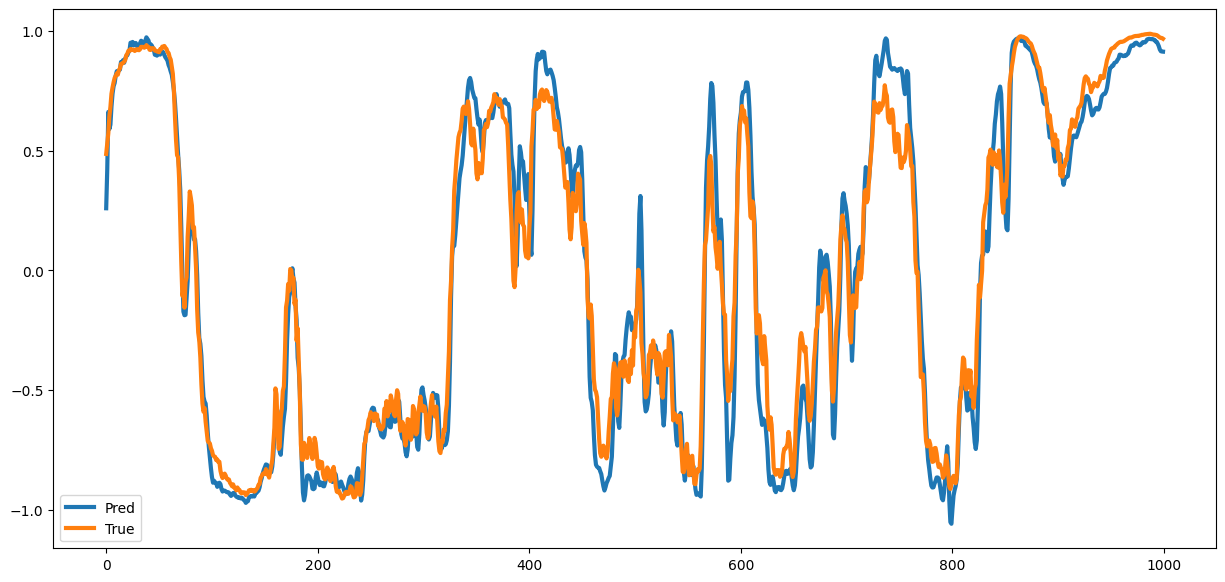

In [8]:
print(WF_y.shape)
sample = 1000
fig = plt.figure(figsize=(15, 7))
plt.plot(np.arange(sample), WF_y[:sample,0], lw=3, label="Pred")
plt.plot(np.arange(sample), WF_testY[0,:sample], lw=3, label="True")
plt.legend()
plt.show()


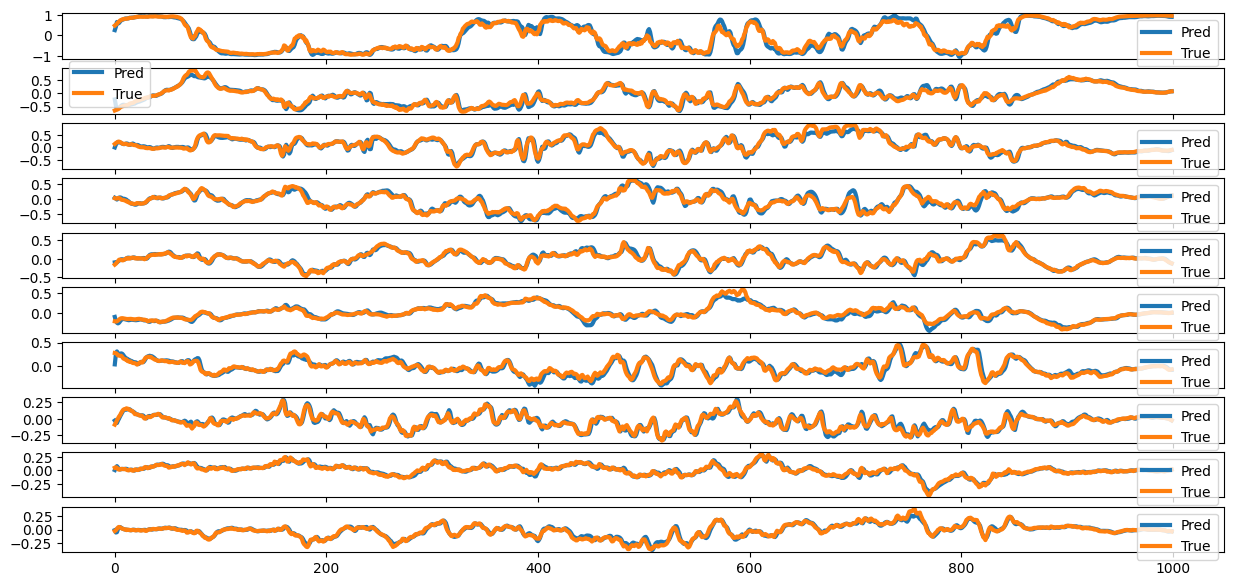

In [9]:
fig = plt.figure(figsize=(15, 7))
for j in range(10):
    plt.subplot(10,1,j+1)
    plt.plot(np.arange(sample), WF_y[:sample,j], lw=3, label="Pred")
    plt.plot(np.arange(sample), WF_testY[j,:sample], lw=3, label="True")
    plt.legend()
plt.show()

Running Model-1: 1000it [00:00, 13320.66it/s]         

(1000, 10)


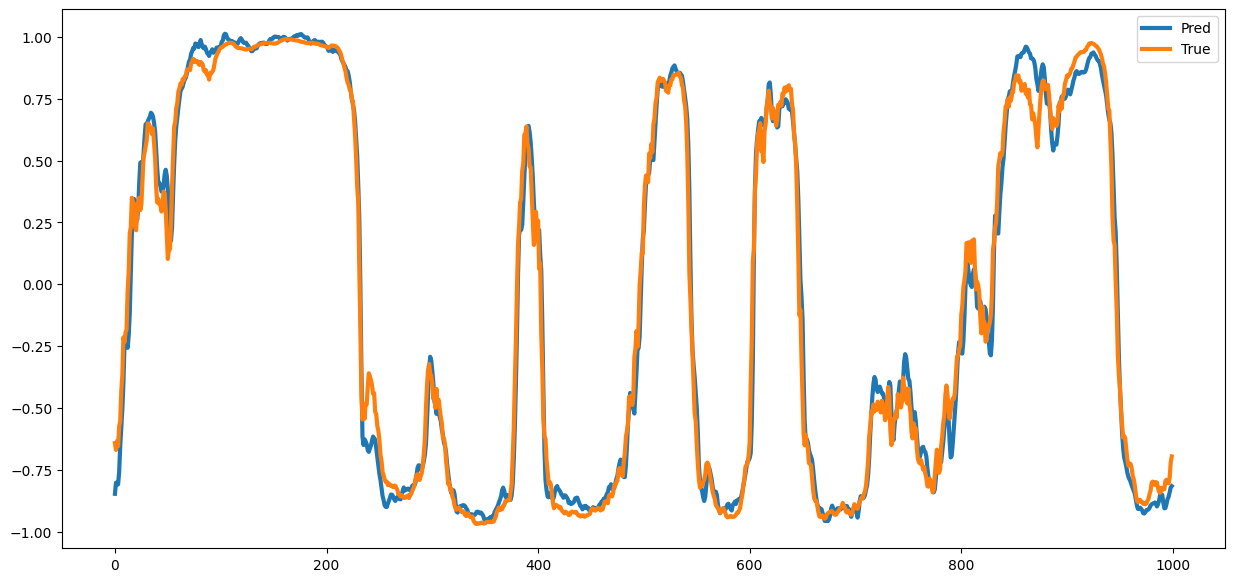

In [10]:
WF_testX2 = WF_data_scaled[:10,7000:8000]
WF_testY2 = WF_data_scaled[:10,7001:8001]

WF_y = esn.run(WF_testX2.T)

print(WF_y.shape)
sample = 1000
fig = plt.figure(figsize=(15, 7))
plt.plot(np.arange(sample), WF_y[:sample,0], lw=3, label="Pred")
plt.plot(np.arange(sample), WF_testY2[0,:sample], lw=3, label="True")
plt.legend()
plt.show()

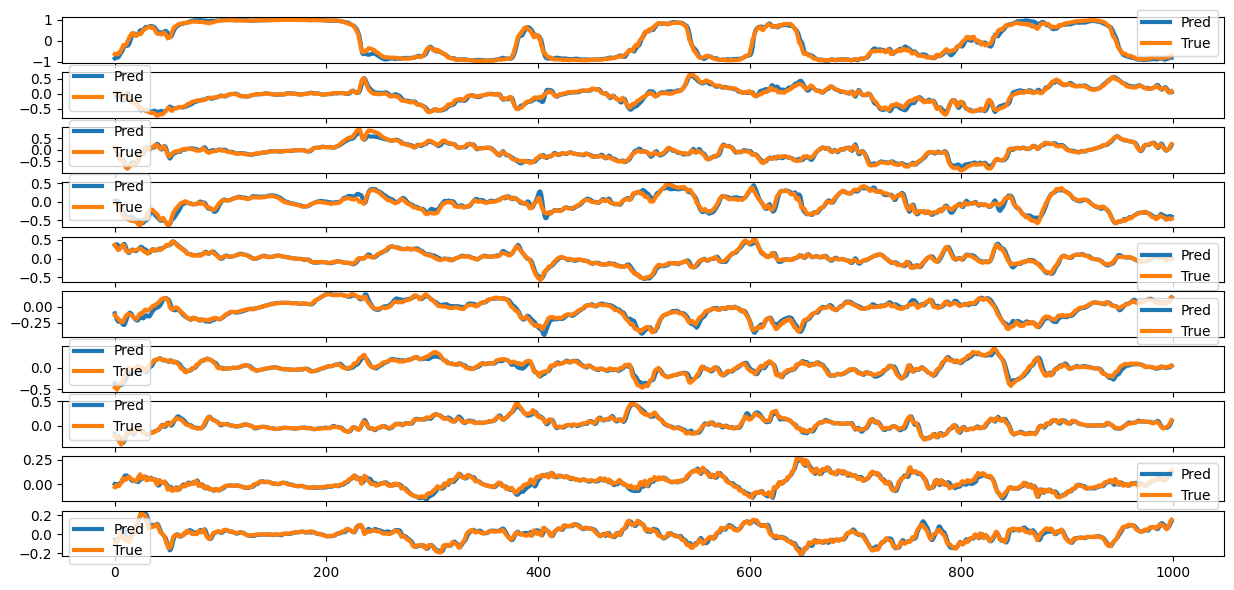

In [11]:
fig = plt.figure(figsize=(15, 7))
for j in range(10):
    plt.subplot(10,1,j+1)
    plt.plot(np.arange(sample), WF_y[:sample,j], lw=3, label="Pred")
    plt.plot(np.arange(sample), WF_testY2[j,:sample], lw=3, label="True")
    plt.legend()
plt.show()

In [12]:
seed_timesteps = 100

warming_inputs = WF_testX[:,:seed_timesteps]

warming_out = esn.run(warming_inputs.T, reset=True)  # warmup

nb_generations = 1000

X_gen = np.zeros((nb_generations, 10))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = esn(y)
    X_gen[t, :] = y

Running Model-1: 100it [00:00, 12564.94it/s]          


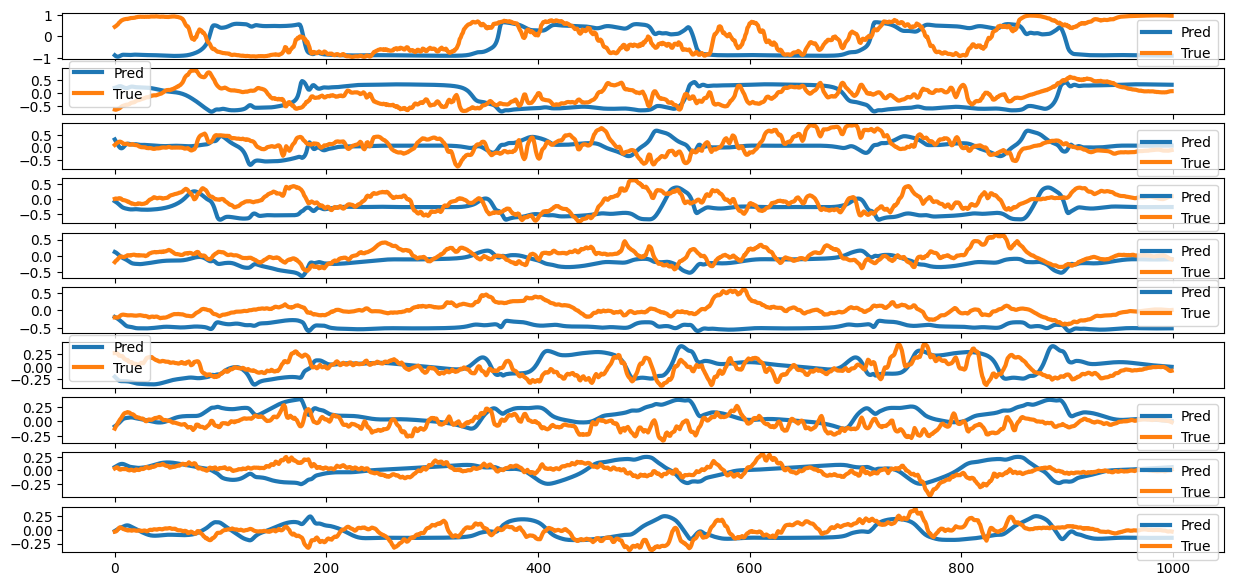

In [13]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
for j in range(10):
    plt.subplot(10,1,j+1)
    plt.plot(np.arange(sample), X_gen[:sample,j], lw=3, label="Pred")
    plt.plot(np.arange(sample), WF_testX[j,:sample], lw=3, label="True")
    plt.legend()
plt.show()

Running Model-1: 10it [00:00, 8086.18it/s]            


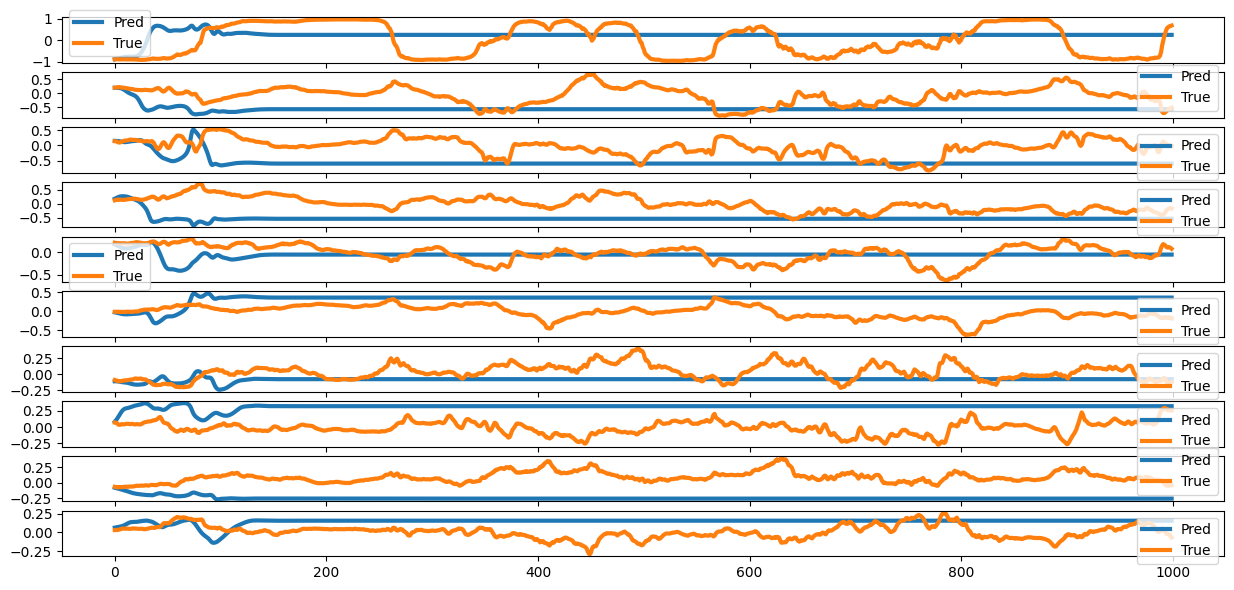

In [14]:
seed_timesteps = 10

warming_inputs = WF_trainX[:,:seed_timesteps]

warming_out = esn.run(warming_inputs.T, reset=True)  # warmup

nb_generations = 1000

X_gen = np.zeros((nb_generations, 10))
y = warming_out[-1]
for t in range(nb_generations):  # generation
    y = esn(y)
    X_gen[t, :] = y
    
sample = 1000

fig = plt.figure(figsize=(15, 7))
for j in range(10):
    plt.subplot(10,1,j+1)
    plt.plot(np.arange(sample), X_gen[:sample,j], lw=3, label="Pred")
    plt.plot(np.arange(sample), WF_trainX[j,:sample], lw=3, label="True")
    plt.legend()
plt.show()